## 21AIE312 Deep Learning for Signal and Image Processing
### Final Project Presentation
---

# Breast Cancer Classification

---
#### DONE BY:
#### Rohith G

In [37]:
# Importing the necessary packages/libraries
import os
import cv2
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt
import tensorflow as tf
import pathlib
import glob
# from osgeo import gdal
import tensorflow_hub as hub
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import random

# pip install --global-option=build_ext --global-option="-I/usr/include/gdal" GDAL==3.4.2

In [38]:
def load_img(path, siz):
    cv_img = []
    count = 0
    for img in glob.glob(path):
        count += 1
        n = cv2.imread(img)
        n = cv2.resize(n, (siz,siz), interpolation = cv2.INTER_AREA)
        cv_img.append(n)
        #if(count >= max_img):
        #    break
    return cv_img

In [39]:
def load_data(classes, path, siz):
    for i in range(0, len(classes)):
        Path = path + "/" + classes[i] + "/*.tif"
        # print(Path)
        X_i = load_img(Path, siz)
        if(i > 0):
            label_i = i*np.ones(len(X_i))
            X = X + X_i
            Y = np.concatenate((Y, label_i) ,axis = None)
        elif(i == 0):
            X = X_i
            Y = np.zeros(len(X_i))
        # print(X_i)
    return X,Y

In [40]:
# Maximum images per class
# max_img = 100

# Path of dataset
pathTrain = "C:/Users/iamta/Desktop/ICIAR2018_BACH_Challenge/Photos"
pathTest = "C:/Users/iamta/Desktop/ICIAR2018_BACH_Challenge_TestDataset/Photos"

# No. of pixels in width and height of the image
# Actual Size = [2048, 1536]
siz = 512

# Class Names
classes = ['Benign', 'InSitu', 'Invasive', 'Normal']
X_train, y_train = load_data(classes, pathTrain, siz)
# X_test, y_test = load_data(classes, pathTest, siz)

In [41]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [42]:
# Splitting for training dataset and putting 20% to test dataset
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [43]:
print("x_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", X_test.shape)
print("y_test shape", y_test.shape)

x_train shape (400, 512, 512, 3)
y_train shape (400,)
x_test shape (0,)
y_test shape (0,)


In [44]:
n_classes = len(classes)
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)
Y_test = np_utils.to_categorical(y_test, n_classes)

Shape before one-hot encoding:  (400,)
Shape after one-hot encoding:  (400, 4)


In [53]:
def Random_example_img(X, Y, x=4, y=5):
    fig = plt.figure(figsize = (12,8))
    fig.suptitle("Random Examples from Training Dataset", fontsize = 28)
    for i in range(x*y):
        plt.subplot(x,y,i+1)
        plt.xticks([])
        plt.yticks([])
        rand = random.randint(0,len(X))
        plt.imshow(X[rand])
        plt.xlabel(classes[np.argmax(Y,axis=1)[rand]], fontsize=12)
    plt.show()

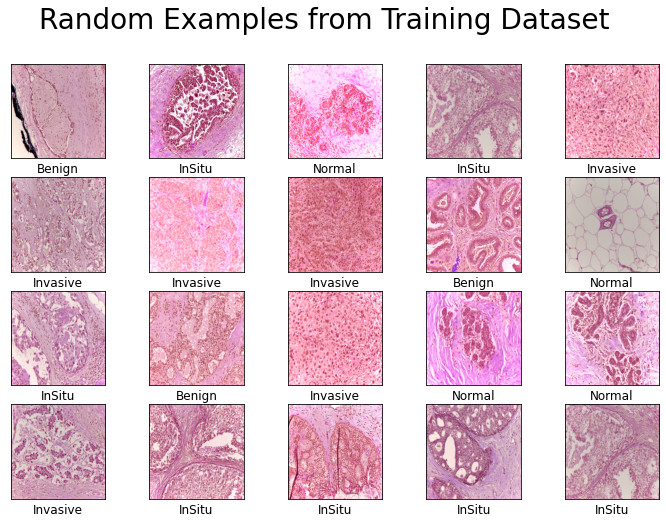

In [54]:
Random_example_img(X_train, Y_train)

# CROSS VALIDATE BLENDING

#!/usr/bin/env python3
"""Do cross-validation, output and dump statistics in data/roc_scores.pkl,
data/conf_mx.pkl, submission/crossvalidation.csv"""

import pickle
from os.path import join
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from utils import load_data
import pandas as pd
import argparse


PREDS_DIR = "predictions/"
N_FOLDS = 10
N_SEEDS = 5
DEFAULT_N_CLASSES = 4

USE_PREDICTIONS = True
LGBM_MODELS_ROOT = "models/LGBMs"
DEFAULT_PREPROCESSED_ROOT = "data/preprocessed/train/"
with open("data/folds-10.pkl", "rb") as f:
    folds = pickle.load(f)
AUGMENTATIONS_PER_IMAGE = 50

models = [
    "ResNet-0.5-400",
    "ResNet-0.5-650",
    "VGG-0.5-400",
    "VGG-0.5-650",
    "Inception-0.5-400",
    "Inception-0.5-650",
]


def combine_model_scores(scores, y=None, cross_val=True):
    """
    Combine predictions across multiple models and augmentations and return labels.
    By default we use simple average without optimization on predicted labels (y=None)
    Arguments
        scores: Numpy array of probabilities, (n_models x n_samples x augmentations x n_classes)
        y: true labels, (n_samples,). Simple average if None. Logistic regression if given.
        cross_val: when y is given, blend via one-out cross-validation if True. Blend in-sample if False.
    Returns
        y_pred: labels, (n_samples,)
    """
    if y is None:
        return np.argmax(scores.mean(axis=(0, 2)), axis=1), scores.mean(axis=(0, 2))
    else:
        n_models, n_samples, n_aug, n_classes = scores.shape
        y = np.repeat(y[:, None], n_aug, axis=1)
        lr = LogisticRegression()
        if cross_val:
            pred = np.zeros((len(y), n_classes))
            for i in range(n_samples):
                idx = [k for k in range(len(y)) if k != i]
                x_train = scores[:, idx, ...].transpose(1, 2, 3, 0).reshape((n_samples - 1) * n_aug,
                                                                            n_models * n_classes)
                y_train = y[idx].flatten()
                x_test = scores[:, i, ...].transpose(1, 2, 0).reshape(n_aug, n_models * n_classes)
                lr.fit(x_train, y_train)
                pred[i] = lr.predict_proba(x_test).mean(axis=0)
        else:
            x = scores.transpose(1, 2, 3, 0).reshape(n_samples * n_aug, n_models * n_classes)
            lr.fit(x, y.flatten())
            pred = lr.predict_proba(x)
            pred = pred.reshape(n_samples, n_aug, n_classes).mean(axis=1)
        return np.argmax(pred, axis=1), pred


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    arg = parser.add_argument
    arg("--features",
        required=False,
        default=DEFAULT_PREPROCESSED_ROOT,
        metavar="",
        help="Feature root dir. Default: data/preprocessed/train")
    arg("--n_classes",
        required=False,
        default=DEFAULT_N_CLASSES,
        type=int, choices=[2, 4],
        metavar="",
        help="Number of classes. Can be 2 or 4. Default: 4")
    arg("-predict",
        action="store_true",
        default=False,
        help="Predict folds during blending, do not use pre-saved CV predictions")
    args = parser.parse_args()
    PREPROCESSED_ROOT = args.features
    N_CLASSES = args.n_classes
    USE_PREDICTIONS = not args.predict

    blended_scores = []
    y_true = []
    y_pred = []
    scores = []
    files = []
    verification = defaultdict(dict)
    for fold in range(N_FOLDS):
        y_true_f = []
        scores_f = []
        files_f = []
        for model_name in models:
            name, scale, crop = model_name.split("-")
            scores_seeded = []
            for seed in range(N_SEEDS):
                if USE_PREDICTIONS:
                    # use pre-saved predictions
                    preds_file = "lgbm_preds-{}-{}-{}-f{}-s{}.pkl".format(name, scale, crop, fold, seed)
                    with open(join(PREDS_DIR, name, preds_file), "rb") as f:
                        preds = pickle.load(f)
                else:
                    # predict during CV
                    model_file = "lgbm-{}-{}-{}-f{}-s{}.pkl".format(name, scale, crop, fold, seed)
                    with open(join(LGBM_MODELS_ROOT, name, model_file), "rb") as f:
                        model = pickle.load(f)
                    _, _, x_test, y_test = load_data(join(PREPROCESSED_ROOT, "{}-{}-{}".format(name, scale, crop)),
                                                     folds, fold)
                    sc = model.predict(x_test)
                    sc = sc.reshape(-1, AUGMENTATIONS_PER_IMAGE, DEFAULT_N_CLASSES)
                    preds = {
                        "files": folds[fold]["test"]["x"],
                        "y_true": y_test,
                        "scores": sc,
                    }
                n_samples, apm, _ = preds["scores"].shape  # apm ~ AUGMENTATIONS_PER_IMAGE
                scores_seeded.append(preds["scores"])  # N_SEEDS * (N x AUGMENTATIONS_PER_IMAGE x NUM_CLASSES))
                y_true_f.append(preds["y_true"][::apm])
                files_f.append(preds["files"])
            scores_seeded = np.stack(scores_seeded)  # (N_SEEDS x N x AUGMENTATIONS_PER_IMAGE x NUM_CLASSES)

            # used to compare with seeds x folds stats for a model obtained during training
            verification[model_name][fold] = scores_seeded  # (N_SEEDS x N x AUGMENTATIONS_PER_IMAGE x NUM_CLASSES)

            # average across seeds, we do not need them anymore
            scores_f.append(scores_seeded.mean(axis=0))  # (N x AUGMENTATIONS_PER_IMAGE x NUM_CLASSES)

        y_true_f = np.stack(y_true_f)
        assert np.all(y_true_f == y_true_f[0])
        files_f = np.stack(files_f)
        assert np.all(files_f == files_f[0])
        y_true.append(y_true_f[0])
        files.append(files_f[0])

        scores_f = np.stack(scores_f)
        y_pred_f, scores_f = combine_model_scores(scores_f, y=None, cross_val=True)
        y_pred.append(y_pred_f)
        scores.append(scores_f)

    if N_CLASSES == 2:
        for fold in range(N_FOLDS):
            # scores[i] = scores[i].reshape(-1, 2, 2).sum(axis=-1)
            scores[fold] = scores[fold].reshape(-1, 2, 2).max(axis=-1)
            scores[fold] = scores[fold] / scores[fold].sum(axis=-1, keepdims=True)
            y_pred[fold][y_pred[fold] == 1] = 0
            y_pred[fold][y_pred[fold] > 1] = 1
            y_true[fold][y_true[fold] == 1] = 0
            y_true[fold][y_true[fold] > 1] = 1

            for model_name in models:
                v = verification[model_name][fold]
                N = v.shape[1]
                v = v.reshape(N_SEEDS, N, AUGMENTATIONS_PER_IMAGE, 2, 2).max(axis=-1)
                verification[model_name][fold] = v / v.sum(axis=-1, keepdims=True)

    # verify predictions
    all_models_folds = np.zeros((len(models), N_FOLDS))
    for m_i, model_name in enumerate(models):
        model_preds = []
        for fold in range(N_FOLDS):
            # (N_SEEDS x N x AUGMENTATIONS_PER_IMAGE x NUM_CLASSES)
            fold_preds = verification[model_name][fold].mean((0, 2)).argmax(-1)
            model_preds.append(fold_preds)
            all_models_folds[m_i, fold] = accuracy_score(y_true[fold], fold_preds)
        model_acc = accuracy_score(np.concatenate(y_true), np.concatenate(model_preds))
        print("{}: average across seeds: [{}]. All folds {}({:0.2})".
              format(model_name, ", ".join(map(lambda s: "{:5.3}".format(s), all_models_folds[m_i])),
                     model_acc, all_models_folds[m_i].std()))
    print()
    print("Std across models: [{}]. All folds {:5.3}".
          format(", ".join(map(lambda s: "{:5.3}".format(s), all_models_folds.std(0))), all_models_folds.std(0).mean()))
    acc_folded = np.array([accuracy_score(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)])  # y_true, y_pred contain folds
    acc_blend = accuracy_score(np.concatenate(y_true), np.concatenate(y_pred))
    print("Blended model: [{}], mean {:5.3}, std {:5.3}".format(", ".join(map(lambda s: "{:5.3}".format(s), acc_folded)),
                                                                acc_blend, acc_folded.std()))

    # Dump crossvalidation stats
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    scores = np.concatenate(scores)
    files = np.concatenate(files)

    if N_CLASSES == 2:
        with open("data/roc_scores.pkl", "wb") as f:
            pickle.dump((scores, y_true), f)
    elif N_CLASSES == 4:
        with open("data/conf_mx.pkl", "wb") as f:
            pickle.dump((y_true, y_pred), f)
        CLASSES = ["Normal", "Benign", "InSitu", "Invasive"]
        labels = [CLASSES[i] for i in y_pred]
        df = pd.DataFrame(list(zip(map(lambda s: s.replace(".npy", ".tif"), files), labels)), columns=["image", "label"])
        df = df.sort_values("image")
        df.to_csv("submission/crossvalidation.csv", header=False, index=False)

"""
2-class Blended model: [ 0.95, 0.925,   0.9, 0.975, 0.925, 0.975, 0.925, 0.925,  0.95, 0.925], mean 0.938, std 0.023
4-class Blended model: [0.925, 0.825, 0.875, 0.875, 0.875,   0.9,  0.85, 0.875, 0.875,  0.85], mean 0.873, std 0.0261
"""

# DOWNLOAD MODELS

#!/usr/bin/env python3
# """Download and populate directories with models, features and CV predictions. Partially borrowed from Keras distribution"""

import os
import zipfile
import hashlib
from six.moves.urllib.error import URLError
from six.moves.urllib.request import urlretrieve
import argparse
from tqdm import tqdm


# DEFAULT_MD5 = "5d92cd351ada73ccbc7a15c879a65b40"
DEFAULT_MD5 = "5A3C6F5EC649562ABD6013DE988D1AAE"
DEFAULT_FNAME = "ICIAR2018_data.zip"
# DEFAULT_URL = "https://www.dropbox.com/s/1vwsfekuxc50cfm/ICIAR2018_data.zip?dl=1"
DEFAULT_URL = "https://www.dropbox.com/s/oklwgz5v9suyj1k/ICIAR2018_data.zip?dl=1"


def _extract_archive(file_path, path="."):
    """Extracts an archive of zip format.
    # Arguments
        file_path: path to the archive file
        path: path to extract the archive file
    # Returns
        True if a match was found and an archive extraction was completed,
        False otherwise.
    """
    open_fn = zipfile.ZipFile
    is_match_fn = zipfile.is_zipfile

    if is_match_fn(file_path):
        with open_fn(file_path) as archive:
            try:
                archive.extractall(path)
            except (RuntimeError, KeyboardInterrupt):
                raise
        return True


class TqdmUpTo(tqdm):
    """Provides `update_to(n)` which uses `tqdm.update(delta_n)`."""
    def update_to(self, b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)  # will also set self.n = b * bsize


def get_file(fname, origin, extract=False, md5_hash=None):
    """Downloads a file from a URL if it not already present.
    Files in zip formats can also be extracted.
    Passing a hash will verify the file after download.
    # Arguments
        fname: Name of the file. If an absolute path `/path/to/file.txt` is
            specified the file will be saved at that location.
        origin: Original URL of the file.
        md5_hash: md5 hash of the file for verification.
    # Returns
        Path to the downloaded file
    """
    fpath = fname
    download = False
    if os.path.exists(fpath):
        # File found; verify integrity if a hash was provided.
        if md5_hash is not None:
            if not validate_file(fpath, md5_hash, algorithm="md5"):
                print("A local file was found, but it seems to be "
                      "incomplete or outdated because the md5 "
                      "file hash does not match the original value of " +
                      md5_hash + " so we will re-download the data.")
                download = True
            else:
                print("A local file was found and "
                      "file hash matches the original value "
                      "so we do not re-download the data.")
    else:
        download = True

    if download:
        print("Downloading data from", origin)
        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                with TqdmUpTo(unit="B", unit_scale=True, miniters=1,
                              desc=fpath.split("/")[-1]) as t:  # all optional kwargs
                    urlretrieve(origin, fpath, reporthook=t.update_to, data=None)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise
    if extract:
        _extract_archive(fpath)

    return fpath


def _hash_file(fpath, algorithm="sha256", chunk_size=65535):
    """Calculates a file sha256 or md5 hash.
    # Example
    ```python
       >>> from keras.data_utils import _hash_file
       >>> _hash_file("/path/to/file.zip")
       "e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855"
    ```
    # Arguments
        fpath: path to the file being validated
        algorithm: hash algorithm, one of "auto", "sha256", or "md5".
            The default "auto" detects the hash algorithm in use.
        chunk_size: Bytes to read at a time, important for large files.
    # Returns
        The file hash
    """
    hasher = hashlib.md5()

    with open(fpath, "rb") as fpath_file:
        for chunk in iter(lambda: fpath_file.read(chunk_size), b""):
            hasher.update(chunk)

    return hasher.hexdigest()


def validate_file(fpath, file_hash, algorithm="auto", chunk_size=65535):
    """Validates a file against a sha256 or md5 hash.
    # Arguments
        fpath: path to the file being validated
        file_hash:  The expected hash string of the file.
            The sha256 and md5 hash algorithms are both supported.
        algorithm: Hash algorithm, one of "auto", "sha256", or "md5".
            The default "auto" detects the hash algorithm in use.
        chunk_size: Bytes to read at a time, important for large files.
    # Returns
        Whether the file is valid
    """
    if ((algorithm is "sha256") or
            (algorithm is "auto" and len(file_hash) is 64)):
        hasher = "sha256"
    else:
        hasher = "md5"

    if str(_hash_file(fpath, hasher, chunk_size)) == str(file_hash):
        return True
    else:
        return False


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    arg = parser.add_argument
    arg("--url",
        required=False,
        default=DEFAULT_URL,
        metavar="url",
        help="Original URL of the file.")
    arg("--fname",
        required=False,
        default=DEFAULT_FNAME,
        metavar="fname",
        help="Local file name.")
    arg("--md5",
        required=False,
        default=DEFAULT_MD5,
        metavar="md5",
        help="Feature root dir. Default: data/preprocessed/train")
    arg("-dnx",
        action="store_true",
        default=False,
        help="Do not extract archive after download.")
    args = parser.parse_args()
    url = args.url
    fname = args.fname
    md5 = args.md5
    extract = not args.dnx

    get_file(fname, url, extract=extract, md5_hash=md5)

# FEATRUE EXTRACTOR

#!/usr/bin/env python3
"""Extract deep CNN features from a set of images and dump them as Numpy arrays image_file_name.npy"""

import argparse
import numpy as np
import cv2
from scipy import ndimage
from os.path import basename, join, exists
from os import makedirs
from threaded_generator import threaded_generator
from time import time
import sys
np.random.seed(13)

PATCH_SIZES = [400, 650]
SCALES = [0.5]

DEFAULT_INPUT_DIR = "data/train"
DEFAULT_PREPROCESSED_ROOT = "data/preprocessed/train"

PATCHES_PER_IMAGE = 20
AUGMENTATIONS_PER_IMAGE = 50
COLOR_LO = 0.7
COLOR_HI = 1.3
BATCH_SIZE = 16     # decrease if necessary

NUM_CACHED = 160


def recursive_glob(root_dir, file_template="*.tif"):
    """Traverse directory recursively. Starting with Python version 3.5, the glob module supports the "**" directive"""

    if sys.version_info[0] * 10 + sys.version_info[1] < 35:
        import fnmatch
        import os
        matches = []
        for root, dirnames, filenames in os.walk(root_dir):
            for filename in fnmatch.filter(filenames, file_template):
                matches.append(os.path.join(root, filename))
        return matches
    else:
        import glob
        return glob.glob(root_dir + "/**/" + file_template, recursive=True)


def normalize_staining(img):
    """
    Adopted from "Classification of breast cancer histology images using Convolutional Neural Networks",
    Teresa Araújo , Guilherme Aresta, Eduardo Castro, José Rouco, Paulo Aguiar, Catarina Eloy, António Polónia,
    Aurélio Campilho. https://doi.org/10.1371/journal.pone.0177544
    Performs staining normalization.
    # Arguments
        img: Numpy image array.
    # Returns
        Normalized Numpy image array.
    """
    Io = 240
    beta = 0.15
    alpha = 1
    HERef = np.array([[0.5626, 0.2159],
                      [0.7201, 0.8012],
                      [0.4062, 0.5581]])
    maxCRef = np.array([1.9705, 1.0308])

    h, w, c = img.shape
    img = img.reshape(h * w, c)
    OD = -np.log((img.astype("uint16") + 1) / Io)
    ODhat = OD[(OD >= beta).all(axis=1)]
    W, V = np.linalg.eig(np.cov(ODhat, rowvar=False))

    Vec = -V.T[:2][::-1].T  # desnecessario o sinal negativo
    That = np.dot(ODhat, Vec)
    phi = np.arctan2(That[:, 1], That[:, 0])
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)
    vMin = np.dot(Vec, np.array([np.cos(minPhi), np.sin(minPhi)]))
    vMax = np.dot(Vec, np.array([np.cos(maxPhi), np.sin(maxPhi)]))
    if vMin[0] > vMax[0]:
        HE = np.array([vMin, vMax])
    else:
        HE = np.array([vMax, vMin])

    HE = HE.T
    Y = OD.reshape(h * w, c).T

    C = np.linalg.lstsq(HE, Y)
    maxC = np.percentile(C[0], 99, axis=1)

    C = C[0] / maxC[:, None]
    C = C * maxCRef[:, None]
    Inorm = Io * np.exp(-np.dot(HERef, C))
    Inorm = Inorm.T.reshape(h, w, c).clip(0, 255).astype("uint8")

    return Inorm


def hematoxylin_eosin_aug(img, low=0.7, high=1.3, seed=None):
    """
    "Quantification of histochemical staining by color deconvolution"
    Arnout C. Ruifrok, Ph.D. and Dennis A. Johnston, Ph.D.
    http://www.math-info.univ-paris5.fr/~lomn/Data/2017/Color/Quantification_of_histochemical_staining.pdf
    Performs random hematoxylin-eosin augmentation
    # Arguments
        img: Numpy image array.
        low: Low boundary for augmentation multiplier
        high: High boundary for augmentation multiplier
    # Returns
        Augmented Numpy image array.
    """
    D = np.array([[1.88, -0.07, -0.60],
                  [-1.02, 1.13, -0.48],
                  [-0.55, -0.13, 1.57]])
    M = np.array([[0.65, 0.70, 0.29],
                  [0.07, 0.99, 0.11],
                  [0.27, 0.57, 0.78]])
    Io = 240

    h, w, c = img.shape
    OD = -np.log10((img.astype("uint16") + 1) / Io)
    C = np.dot(D, OD.reshape(h * w, c).T).T
    r = np.ones(3)
    r[:2] = np.random.RandomState(seed).uniform(low=low, high=high, size=2)
    img_aug = np.dot(C * r, M)

    img_aug = Io * np.exp(-img_aug * np.log(10)) - 1
    img_aug = img_aug.reshape(h, w, c).clip(0, 255).astype("uint8")
    return img_aug


def zoom_aug(img, zoom_var, seed=None):
    """Performs a random spatial zoom of a Numpy image array.
    # Arguments
        img: Numpy image array.
        zoom_var: zoom range multiplier for width and height.
        seed: Random seed.
    # Returns
        Zoomed Numpy image array.
    """
    scale = np.random.RandomState(seed).uniform(low=1 / zoom_var, high=zoom_var)
    resized_img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    return resized_img


def get_crops(img, size, n, seed=None):
    """Creates random square crops of given size from a Numpy image array. No rotation added
    # Arguments
        img: Numpy image array.
        size: size of crops.
        n: number of crops
        seed: Random seed.
    # Returns
        Numpy array of crops, shape (n, size, size, c).
    """
    h, w, c = img.shape
    assert all([size < h, size < w])
    crops = []
    for _ in range(n):
        top = np.random.randint(low=0, high=h - size + 1)
        left = np.random.randint(low=0, high=w - size + 1)
        crop = img[top: top + size, left: left + size].copy()
        crop = np.rot90(crop, np.random.randint(low=0, high=4))
        if np.random.random() > 0.5:
            crop = np.flipud(crop)
        if np.random.random() > 0.5:
            crop = np.fliplr(crop)
        crops.append(crop)

    crops = np.stack(crops)
    assert crops.shape == (n, size, size, c)
    return crops


def get_crops_free(img, size, n, seed=None):
    """Creates random square crops of given size from a Numpy image array. With rotation
    # Arguments
        img: Numpy image array.
        size: size of crops.
        n: number of crops
        seed: Random seed.
    # Returns
        Numpy array of crops, shape (n, size, size, c).
    """
    h, w, c = img.shape
    assert all([size < h, size < w])
    d = int(np.ceil(size / np.sqrt(2)))
    crops = []
    for _ in range(n):
        center_y = np.random.randint(low=0, high=h - size + 1) + size // 2
        center_x = np.random.randint(low=0, high=w - size + 1) + size // 2
        m = min(center_y, center_x, h - center_y, w - center_x)
        if m < d:
            max_angle = np.pi / 4 - np.arccos(m / d)
            top = center_y - m
            left = center_x - m
            precrop = img[top: top + 2 * m, left: left + 2 * m]
        else:
            max_angle = np.pi / 4
            top = center_y - d
            left = center_x - d
            precrop = img[top: top + 2 * d, left: left + 2 * d]

        precrop = np.rot90(precrop, np.random.randint(low=0, high=4))
        angle = np.random.uniform(low=-max_angle, high=max_angle)
        precrop = ndimage.rotate(precrop, angle * 180 / np.pi, reshape=False)

        precrop_h, precrop_w, _ = precrop.shape
        top = (precrop_h - size) // 2
        left = (precrop_w - size) // 2
        crop = precrop[top: top + size, left: left + size]

        if np.random.random() > 0.5:
            crop = np.flipud(crop)
        if np.random.random() > 0.5:
            crop = np.fliplr(crop)
        crops.append(crop)

    crops = np.stack(crops)
    assert crops.shape == (n, size, size, c)
    return crops


def norm_pool(features, p=3):
    """Performs descriptor pooling
    # Arguments
        features: Numpy array of descriptors.
        p: degree of pooling.
    # Returns
        Numpy array of pooled descriptor.
    """
    return np.power(np.power(features, p).mean(axis=0), 1/p)


def encode(crops, model):
    """Encodes crops
    # Arguments
        crops: Numpy array of crops.
        model: Keras encoder.
    # Returns
        Numpy array of pooled descriptor.
    """
    features = model.predict(crops)
    pooled_features = norm_pool(features)
    return pooled_features


def process_image(image_file):
    """Extract multiple crops from a single image
    # Arguments
        image_file: Path to image.
    # Yields
        Numpy array of image crops.
    """
    img = cv2.imread(image_file)
    if SCALE != 1:
        img = cv2.resize(img, None, fx=SCALE, fy=SCALE, interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_norm = normalize_staining(img)

    for _ in range(AUGMENTATIONS_PER_IMAGE):
        img_aug = hematoxylin_eosin_aug(img_norm, low=COLOR_LO, high=COLOR_HI)
        # img_aug = zoom_aug(img_aug, ZOOM_VAR)

        # single_image_crops = get_crops_free(img_aug, PATCH_SZ, PATCHES_PER_IMAGE)
        single_image_crops = get_crops(img_aug, PATCH_SZ, PATCHES_PER_IMAGE)
        yield single_image_crops


def crops_gen(file_list):
    """Generates batches of crops from image list, one augmentation a time
    # Arguments
        file_list: List of image files.
    # Yields
        Tuple of Numpy array of image crops and name of the file.
    """
    for i, (image_file, output_file) in enumerate(file_list):
        print("Crops generator:", i + 1)
        for crops in process_image(image_file):
            yield crops, output_file


def features_gen(crops_and_output_file, model):
    """Processes crop generator, encodes them and dumps pooled descriptors
    # Arguments
        crops_and_output_file: generator of crops and file names.
        model: Keras encoder.
    # Returns: None
    """
    ts = time()
    current_file = None
    pooled_features = []
    i = 0
    for j, (crops, output_file) in enumerate(crops_and_output_file):
        if current_file is None:
            current_file = output_file
        features = encode(crops, model)
        if output_file == current_file:
            pooled_features.append(features)
        else:
            np.save(current_file, np.stack(pooled_features))
            pooled_features = [features]
            current_file = output_file
            average_time = int((time() - ts) / (i + 1))
            print("Feature generator: {}, {} sec/image.".format(i + 1, average_time))
            i += 1
    if len(pooled_features) > 0:
        np.save(current_file, np.stack(pooled_features))


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    arg = parser.add_argument
    arg("--images",
        required=False,
        default=DEFAULT_INPUT_DIR,
        metavar="img_dir",
        help="Input image directory. Default: data/train")
    arg("--features",
        required=False,
        default=DEFAULT_PREPROCESSED_ROOT,
        metavar="feat_dir",
        help="Feature root dir. Default: data/preprocessed/train")
    args = parser.parse_args()
    INPUT_DIR = args.images
    PREPROCESSED_ROOT = args.features

    from models import ResNet, Inception, VGG
    NN_MODELS = [ResNet, Inception, VGG]

    input_files = recursive_glob(INPUT_DIR)

    for SCALE in SCALES:
        print("SCALE:", SCALE)
        for NN_MODEL in NN_MODELS:
            print("NN_MODEL:", NN_MODEL.__name__)
            for PATCH_SZ in PATCH_SIZES:
                print("PATCH_SZ:", PATCH_SZ)
                PREPROCESSED_PATH = join(PREPROCESSED_ROOT, "{}-{}-{}".format(NN_MODEL.__name__, SCALE, PATCH_SZ))
                if not exists(PREPROCESSED_PATH):
                    makedirs(PREPROCESSED_PATH)

                model = NN_MODEL(batch_size=BATCH_SIZE)

                output_files = [join(PREPROCESSED_PATH, basename(f).replace("tif", "npy")) for f in input_files]
                file_list = zip(input_files, output_files)

                crops_and_output_file = crops_gen(file_list)
                crops_and_output_file_ = threaded_generator(crops_and_output_file, num_cached=NUM_CACHED)
                features_gen(crops_and_output_file_, model)

# MODELS

#!/usr/bin/env python3
"""Implement several encoder classes"""

from keras.applications.resnet50 import ResNet50, preprocess_input as preprocess_resnet, decode_predictions
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_inception
from keras.applications.vgg16 import VGG16, preprocess_input as preprocess_vgg
from keras.preprocessing import image
from keras import backend as K
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Concatenate
import numpy as np


class ResNet:
    __name__ = "ResNet"

    def __init__(self, batch_size=32):
        self.model = ResNet50(include_top=False, weights='imagenet', pooling="avg")
        self.batch_size = batch_size
        self.data_format = K.image_data_format()

    def predict(self, x):
        if self.data_format == "channels_first":
            x = x.transpose(0, 3, 1, 2)
        x = preprocess_resnet(x.astype(K.floatx()))
        return self.model.predict(x, batch_size=self.batch_size)


class Inception:
    __name__ = "Inception"

    def __init__(self, batch_size=32):
        self.model = InceptionV3(include_top=False, weights="imagenet", pooling="avg")
        self.batch_size = batch_size
        self.data_format = K.image_data_format()

    def predict(self, x):
        if self.data_format == "channels_first":
            x = x.transpose(0, 3, 1, 2)
        x = preprocess_inception(x.astype(K.floatx()))
        return self.model.predict(x, batch_size=self.batch_size)


class VGG:
    __name__ = "VGG"

    def __init__(self, batch_size=32):
        model = VGG16(include_top=False, weights="imagenet", pooling="avg")
        x2 = GlobalAveragePooling2D()(model.get_layer("block2_conv2").output)  # 128
        x3 = GlobalAveragePooling2D()(model.get_layer("block3_conv3").output)  # 256
        x4 = GlobalAveragePooling2D()(model.get_layer("block4_conv3").output)  # 512
        x5 = GlobalAveragePooling2D()(model.get_layer("block5_conv3").output)  # 512
        x = Concatenate()([x2, x3, x4, x5])
        self.model = Model(inputs=model.input, outputs=x)
        self.batch_size = batch_size
        self.data_format = K.image_data_format()

    def predict(self, x):
        if self.data_format == "channels_first":
            x = x.transpose(0, 3, 1, 2)
        x = preprocess_vgg(x.astype(K.floatx()))
        return self.model.predict(x, batch_size=self.batch_size)


if __name__ == "__main__":
    img_path = "data/elephant.jpg"
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_inception(x)

    model = InceptionV3()
    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print("Predicted:", decode_predictions(preds, top=3)[0])
    # Predicted: [('n02504013', 'Indian_elephant', 0.78864819), ('n01871265', 'tusker', 0.029346621),
    # ('n02504458', 'African_elephant', 0.01768155)]

# SUBMISSION

#!/usr/bin/env python3
"""Generates submission"""
import pickle
from os.path import join
import numpy as np
from utils import load_data
import pandas as pd
import argparse


MODELS_DIR = "models/LGBMs"
DEFAULT_PREPROCESSED_ROOT = "data/preprocessed/test/"
DEFAULT_SUBMISSION_FILE = "submission/submission.csv"

N_FOLDS = 10
N_SEEDS = 5
N_CLASSES = 4
CLASSES = ["Normal", "Benign", "InSitu", "Invasive"]
AUGMENTATIONS_PER_IMAGE = 50

MODELS = [
    "ResNet-0.5-400",
    "ResNet-0.5-650",
    "VGG-0.5-400",
    "VGG-0.5-650",
    "Inception-0.5-400",
    "Inception-0.5-650",
]

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    arg = parser.add_argument
    arg("--features",
        required=False,
        default=DEFAULT_PREPROCESSED_ROOT,
        metavar="feat_dir",
        help="Feature root dir. Default: data/preprocessed/test")
    arg("--submission",
        required=False,
        default=DEFAULT_SUBMISSION_FILE,
        metavar="submission",
        help="Submission file. Default: submission/submission.csv")
    args = parser.parse_args()
    PREPROCESSED_ROOT = args.features
    SUBMISSION_FILE = args.submission

    scores = []
    files = None
    len_x = None
    for fold in range(N_FOLDS):
        for model_name in MODELS:
            name, scale, crop = model_name.split("-")
            for seed in range(N_SEEDS):
                x, fl = load_data(join(PREPROCESSED_ROOT, "{}-{}-{}".format(name, scale, crop)))
                if files is None:
                    files = fl
                    len_x = len(x)
                else:
                    np.testing.assert_array_equal(fl, files)
                    assert len(x) == len_x
                model_file = "lgbm-{}-{}-{}-f{}-s{}.pkl".format(name, scale, crop, fold, seed)
                with open(join(MODELS_DIR, name, model_file), "rb") as f:
                    model = pickle.load(f)

                sc = model.predict(x)
                sc = sc.reshape(-1, AUGMENTATIONS_PER_IMAGE, N_CLASSES)
                scores.append(sc)

    scores = np.stack(scores)   # N_FOLDS*N_MODELS*N_SEEDS x N x AUGMENTATIONS_PER_IMAGE x N_CLASSES
    scores = scores.mean(axis=(0, 2))
    y_pred = np.argmax(scores, axis=1)
    labels = [CLASSES[i] for i in y_pred]

    df = pd.DataFrame(list(zip(map(lambda s: s.replace(".npy", ".tif"), files), labels)), columns=["image", "label"])
    df = df.sort_values("image")
    df.to_csv(SUBMISSION_FILE, header=False, index=False)

# THREADED GENERATOR

#!/usr/bin/env python3
"""Threaded generator. https://github.com/Lasagne/Lasagne/issues/12#issuecomment-59494251"""


def threaded_generator(generator, num_cached=50):
    """Implements threaded generator to produce batches in background thread.
    # Arguments
        generator: an object exposing generator interface.
    # Yields
        Objects generated by generator.
    """
    from queue import Queue

    qu = Queue(maxsize=num_cached)
    sentinel = object()  # guaranteed unique reference

    # define producer (putting items into queue)
    def producer():
        for item in generator:
            qu.put(item)
        qu.put(sentinel)

    # start producer (in a background thread)
    import threading
    thread = threading.Thread(target=producer)
    thread.daemon = True
    thread.start()

    # run as consumer (read items from queue, in current thread)
    item = qu.get()
    while item is not sentinel:
        yield item
        qu.task_done()
        item = qu.get()

# TRAIN LGBM

#!/usr/bin/env python3
"""Trains LightGBM models on various features, data splits. Dumps models and predictions"""

import pickle
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from utils import load_data
from os.path import join, exists
from os import makedirs
import argparse


CROP_SIZES = [400, 650]
SCALES = [0.5]
NN_MODELS = ["ResNet", "Inception", "VGG"]

AUGMENTATIONS_PER_IMAGE = 50
NUM_CLASSES = 4
RANDOM_STATE = 1
N_SEEDS = 5
VERBOSE_EVAL = False
with open("data/folds-10.pkl", "rb") as f:
    FOLDS = pickle.load(f)

LGBM_MODELS_ROOT = "models/LGBMs"
CROSSVAL_PREDICTIONS_ROOT = "predictions"
DEFAULT_PREPROCESSED_ROOT = "data/preprocessed/train"


def _mean(x, mode="arithmetic"):
    """
    Calculates mean probabilities across augmented data
    # Arguments
        x: Numpy 3D array of probability scores, (N, AUGMENTATIONS_PER_IMAGE, NUM_CLASSES)
        mode: type of averaging, can be "arithmetic" or "geometric"
    # Returns
        Mean probabilities 2D array (N, NUM_CLASSES)
    """
    assert mode in ["arithmetic", "geometric"]
    if mode == "arithmetic":
        x_mean = x.mean(axis=1)
    else:
        x_mean = np.exp(np.log(x + 1e-7).mean(axis=1))
        x_mean = x_mean / x_mean.sum(axis=1, keepdims=True)
    return x_mean


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    arg = parser.add_argument
    arg("--features",
        required=False,
        default=DEFAULT_PREPROCESSED_ROOT,
        metavar="feat_dir",
        help="Feature root dir. Default: data/preprocessed/train")
    args = parser.parse_args()
    PREPROCESSED_ROOT = args.features

    learning_rate = 0.1
    num_round = 70
    param = {
        "objective": "multiclass",
        "num_class": NUM_CLASSES,
        "metric": ["multi_logloss", "multi_error"],
        "verbose": 0,
        "learning_rate": learning_rate,
        "num_leaves": 191,
        "feature_fraction": 0.46,
        "bagging_fraction": 0.69,
        "bagging_freq": 0,
        "max_depth": 7,
    }

    for SCALE in SCALES:
        print("SCALE:", SCALE)
        for NN_MODEL in NN_MODELS:
            print("NN_MODEL:", NN_MODEL)
            for CROP_SZ in CROP_SIZES:
                print("PATCH_SZ:", CROP_SZ)
                INPUT_DIR = join(PREPROCESSED_ROOT, "{}-{}-{}".format(NN_MODEL, SCALE, CROP_SZ))
                acc_all_seeds = []
                for seed in range(N_SEEDS):
                    accuracies = []
                    for fold in range(len(FOLDS)):
                        feature_fraction_seed = RANDOM_STATE + seed * 10 + fold
                        bagging_seed = feature_fraction_seed + 1
                        param.update({"feature_fraction_seed": feature_fraction_seed, "bagging_seed": bagging_seed})

                        print("Fold {}/{}, seed {}".format(fold + 1, len(FOLDS), seed))
                        x_train, y_train, x_test, y_test = load_data(INPUT_DIR, FOLDS, fold)
                        train_data = lgb.Dataset(x_train, label=y_train)
                        test_data = lgb.Dataset(x_test, label=y_test)
                        gbm = lgb.train(param, train_data, num_round, valid_sets=[test_data], verbose_eval=VERBOSE_EVAL)

                        # pickle model
                        model_file = "lgbm-{}-{}-{}-f{}-s{}.pkl".format(NN_MODEL, SCALE, CROP_SZ, fold, seed)
                        model_root = join(LGBM_MODELS_ROOT, NN_MODEL)
                        if not exists(model_root):
                            makedirs(model_root)
                        with open(join(model_root, model_file), "wb") as f:
                            pickle.dump(gbm, f)

                        scores = gbm.predict(x_test)
                        scores = scores.reshape(-1, AUGMENTATIONS_PER_IMAGE, NUM_CLASSES)
                        preds = {
                            "files": FOLDS[fold]["test"]["x"],
                            "y_true": y_test,
                            "scores": scores,
                        }
                        preds_file = "lgbm_preds-{}-{}-{}-f{}-s{}.pkl".format(NN_MODEL, SCALE, CROP_SZ,
                                                                              fold, seed)
                        preds_root = join(CROSSVAL_PREDICTIONS_ROOT, NN_MODEL)
                        if not exists(preds_root):
                            makedirs(preds_root)
                        with open(join(preds_root, preds_file), "wb") as f:
                            pickle.dump(preds, f)

                        mean_scores = _mean(scores, mode="arithmetic")
                        y_pred = np.argmax(mean_scores, axis=1)
                        y_true = y_test[::AUGMENTATIONS_PER_IMAGE]
                        acc = accuracy_score(y_true, y_pred)
                        print("Accuracy:", acc)
                        accuracies.append(acc)

                    acc_seed = np.array(accuracies).mean()  # acc of a seed
                    acc_all_seeds.append(acc_seed)
                    print("{}-{}-{} Accuracies: [{}], mean {:5.3}".format(NN_MODEL, SCALE, CROP_SZ,
                                                                          ", ".join(map(lambda s: "{:5.3}".format(s), accuracies)),
                                                                          acc_seed))
                print("Accuracy of all seeds {:5.3}".format(np.array(acc_all_seeds).mean()))


"""
ResNet-1.0-800
learning_rate = 0.1, 70 steps
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[0.875, 0.725, 0.875, 0.875,   0.8,  0.75,   0.8,  0.85,  0.85,  0.85], mean 0.825
[0.875, 0.775, 0.825, 0.875, 0.775,  0.75,   0.8,  0.85,  0.85, 0.825], mean  0.82
[0.875,  0.75,  0.85,  0.85,   0.8,  0.75, 0.725, 0.875, 0.875, 0.875], mean 0.823
[0.875,  0.75,  0.85,  0.85,   0.8, 0.775, 0.775, 0.825,  0.85, 0.825], mean 0.817
[0.875,  0.75, 0.875, 0.875, 0.775, 0.775, 0.825,  0.85,   0.9,  0.85], mean 0.835
Accuracy of all seeds 0.824
ResNet-1.0-1300
learning_rate = 0.1, 60 steps [0.9, 0.775, 0.825, 0.875, 0.8, 0.775, 0.8, 0.875, 0.85, 0.85]
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[0.925,  0.75,  0.85,  0.85,   0.8, 0.725,   0.8, 0.825,   0.9,  0.85], mean 0.828
[0.875,  0.75,   0.8, 0.875,  0.75, 0.725,   0.8, 0.825, 0.875,  0.85], mean 0.812
[0.875,  0.75,   0.8, 0.825, 0.775, 0.725, 0.825,  0.85,  0.95, 0.875], mean 0.825
[  0.9, 0.775,   0.8,  0.85, 0.725, 0.725,   0.8,   0.8, 0.875, 0.825], mean 0.807
[ 0.85, 0.725,   0.8, 0.825, 0.725,  0.75,   0.8,   0.8, 0.875,  0.85], mean   0.8
Accuracy of all seeds 0.815
VGG-1.0-800
learning_rate = 0.1, 70 steps
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[ 0.85, 0.775, 0.825, 0.875,  0.85, 0.775,   0.8,   0.8,  0.85,   0.8], mean  0.82
[ 0.85,  0.75,  0.85, 0.875, 0.825, 0.775, 0.775, 0.825, 0.875, 0.775], mean 0.818
[ 0.85,  0.75, 0.825, 0.875,  0.85,  0.75, 0.825, 0.825, 0.875,  0.75], mean 0.818
[ 0.85,   0.8, 0.825, 0.875, 0.825,   0.8,   0.8,   0.8, 0.875, 0.775], mean 0.823
[0.825, 0.775, 0.775, 0.875,  0.85, 0.775,   0.8,   0.8,  0.85, 0.725], mean 0.805
Accuracy of all seeds 0.816
VGG-1.0-1300
learning_rate = 0.1, 70 steps
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[0.825,  0.75,   0.8, 0.875, 0.825,   0.8,   0.8,  0.75,  0.85,   0.8], mean 0.807
[0.825,  0.75, 0.825,   0.9,   0.8, 0.825, 0.725, 0.825, 0.875, 0.775], mean 0.812
[ 0.85,   0.8,   0.8, 0.875, 0.775, 0.775, 0.775, 0.775, 0.875, 0.775], mean 0.808
[  0.8, 0.775, 0.775,   0.9,   0.8,   0.8,   0.8, 0.825, 0.875, 0.775], mean 0.812
[0.825, 0.825,   0.8,   0.9,   0.8,   0.8, 0.725,   0.8,  0.85,   0.8], mean 0.812
Accuracy of all seeds  0.81
ResNet-0.5-650
learning_rate = 0.1, 70 steps
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[ 0.95, 0.775, 0.875,   0.9, 0.825, 0.775,  0.85,  0.85,  0.85, 0.825], mean 0.847
[  0.9, 0.775, 0.875,   0.9, 0.775,   0.7, 0.875,   0.8,  0.85, 0.825], mean 0.828
[  0.9, 0.775,  0.85,   0.9, 0.825,  0.75, 0.875, 0.825, 0.825, 0.825], mean 0.835
[0.875, 0.775,  0.85, 0.875,   0.8, 0.725,  0.85, 0.825,  0.85, 0.825], mean 0.825
[0.925, 0.775,  0.85,   0.9, 0.825,  0.75, 0.825,  0.85,  0.85, 0.825], mean 0.838
Accuracy of all seeds 0.834
ResNet-0.5-400
learning_rate = 0.1, 70 steps
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[0.925, 0.825, 0.875, 0.875, 0.775, 0.825, 0.825, 0.825, 0.825, 0.825], mean 0.84
[0.925, 0.775, 0.875, 0.875,   0.8,  0.85,  0.85,   0.8,  0.85, 0.825], mean 0.842
[  0.9, 0.725, 0.875, 0.875, 0.825,  0.85, 0.875,  0.85,  0.85, 0.825], mean 0.845
[0.925, 0.775, 0.875, 0.875,   0.8,  0.85,  0.85,  0.85,  0.85, 0.825], mean 0.847
[0.925, 0.775, 0.825, 0.875, 0.775, 0.825,  0.85, 0.825, 0.825, 0.825], mean 0.833
acc_all_seeds 0.841
VGG-0.5-400
learning_rate = 0.1, 70 steps
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7  
[ 0.85,  0.85,   0.8, 0.825, 0.825,   0.8, 0.825,  0.85, 0.875, 0.825], mean 0.832
[0.875, 0.825,  0.85,  0.85, 0.875,  0.85,   0.8, 0.825, 0.875, 0.825], mean 0.845
[  0.9, 0.825, 0.825,  0.85,  0.85,   0.8,   0.8,  0.85, 0.875,  0.85], mean 0.842
[0.875, 0.825,   0.8,  0.85, 0.825, 0.875,   0.8, 0.775, 0.875, 0.825], mean 0.832
[0.875, 0.825,   0.8, 0.825, 0.825,   0.8,   0.8,   0.8, 0.875, 0.825], mean 0.825
acc_all_seeds 0.835
VGG-0.5-650
learning_rate = 0.1, 70 steps
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[  0.9, 0.825, 0.775,  0.85, 0.825,   0.8, 0.825, 0.875,   0.9,   0.8], mean 0.838
[  0.9, 0.825, 0.775,  0.85,   0.8,   0.8,   0.8, 0.875,   0.9, 0.775], mean  0.83
[  0.9, 0.875, 0.825,  0.85,   0.8,  0.75,   0.8, 0.875,   0.9, 0.825], mean  0.84
[0.875,  0.85,  0.75,  0.85,   0.8,  0.75, 0.825,   0.8, 0.875,   0.8], mean 0.818
[  0.9,   0.9,   0.8,  0.85, 0.825,   0.8, 0.825,  0.85, 0.875, 0.825], mean 0.845
acc_all_seeds 0.8342
Inception_adv-1.0-1300
best acc reached so far 0.67, acc 0.7875, knobs num_leaves 121, feature_fraction 0.34, bagging_fraction 0.69, max_depth 38
learning_rate = 0.1, 60 steps [0.8, 0.85, 0.7375, 0.7875, 0.7375]
learning_rate = 0.1, 60 steps [0.8, 0.85, 0.8, 0.875, 0.8, 0.75, 0.75, 0.8, 0.8, 0.65]
Inception-0.5-650
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
[  0.9, 0.825,  0.75,   0.9,  0.85,   0.8,   0.8,  0.85, 0.775, 0.775], mean 0.823
[0.925,   0.8, 0.725,   0.9,  0.85,   0.8, 0.825, 0.825,   0.8,  0.75], mean  0.82
[  0.9, 0.825,  0.75,   0.9, 0.825, 0.825,  0.85,  0.85, 0.775, 0.775], mean 0.828
[0.925,   0.9, 0.725,   0.9, 0.825, 0.825, 0.825,  0.85,  0.75,  0.75], mean 0.828
[  0.9, 0.875, 0.725,   0.9,  0.85,   0.8,   0.8,  0.85,   0.8,   0.8], mean  0.83
Accuracy of all seeds 0.826
Inception-0.5-400
* new acc reached, loss 0.63, acc 0.825, knobs num_leaves 191, feature_fraction 0.46, bagging_fraction 0.66, max_depth 7
(no data)
"""

# UTILS
#!/usr/bin/env python3
"""Utilities for cross-validation.
Notice data/folds-10.pkl we use in 10-fold cross-val. Keep it to replicate our results"""

import numpy as np
import glob
from os.path import basename, join
from sklearn.model_selection import StratifiedKFold
import pickle


def load_data(in_dir, folds=None, split=None):
    """Builds train/test data from preprocessed features for a given split
    # Arguments
        in_dir: Input directory containing *.npy CNN feature files.
        folds: None or list of splits dict{
                                             "train": {
                                                         "x": train files list,
                                                         "y": train labels},
                                             "test": {
                                                         "x": test files list,
                                                         "y": test labels}}
                                        }
        split: None or split number.
    # Returns
        Tran/test data (features and labels) for a given split, if `folds` is not None
        Test data (only features) and file names, if `folds` is None
    """
    if folds:
        y_train = []
        x_train = []
        for f, l in zip(folds[split]["train"]["x"], folds[split]["train"]["y"]):
            x = np.load(join(in_dir, f))
            x_train.append(x)
            y_train.append([l] * len(x))
        x_train = np.vstack(x_train)
        y_train = np.concatenate(y_train)

        y_test = []
        x_test = []
        for f, l in zip(folds[split]["test"]["x"], folds[split]["test"]["y"]):
            x = np.load(join(in_dir, f))
            x_test.append(x)
            y_test.append([l] * len(x))
        x_test = np.vstack(x_test)
        y_test = np.concatenate(y_test)

        return x_train, y_train, x_test, y_test
    else:
        files = glob.glob(in_dir + "/*.npy")
        x = []
        for f in files:
            x.append(np.load(f))
        return np.vstack(x), np.array([basename(f) for f in files])


def make_folds():
    """Creates stratified splits based on train directory listing
    # Dumps
        folds: list of splits dict{
                                   "train": {
                                               "x": train files list,
                                               "y": train labels},
                                   "test": {
                                               "x": test files list,
                                               "y": test labels}}
                                }
    """
    files = np.array([basename(f) for f in glob.glob("data/preprocessed/train/ResNet-0.5-400/*.npy")])
    labels = []
    classes = np.array([0, 1, 2, 3])
    for f in files:
        lb = np.array([f.startswith("n"),
                       f.startswith("b"),
                       f.startswith("is"),
                       f.startswith("iv")])
        labels.append(classes[np.argmax(lb)])
    labels = np.array(labels)

    folds = []
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for train_index, test_index in skf.split(files, labels):
        f_train, f_test = files[train_index], files[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        folds.append({"train": {"x": f_train, "y": y_train}, "test": {"x": f_test, "y": y_test}})

    with open("data/folds-10.pkl", "wb") as f:
        pickle.dump(folds, f)